# CogPonder: An Interoperable Model of Response Times in Cognitive Tasks

Of our interest is a simultaneous model of speed and accuracy of human responses.

Inspired by [PonderNet](https://arxiv.org/abs/2107.05407), this notebook demonstrate a interoperable model that produces human-like speed-accuracy in decision making tasks.

The model iterates over a recurrent decision network, terminating only when it reaches a halting step. The network is trained to maximize accuracy and minimize the difference between the human response time and the halting step of the network.


## Tasks

### 2-back Task

The subject is presented with a sequence of letters, and are asked to respond with "target" button whe the current stimulus matches the one from n steps earlier in the sequence. The load factor n can be adjusted to make the task more or less difficult.

We use a mock 2-back dataset to evaluate the architecture. The mock dataset includes trial-level $X$, $responses$, $targets$, and $response\_times$ for each subject.


### Decision Model

We want to learn a supervised approximation of the $X \to y$ as follows:

$
f: X,h_n \mapsto \tilde{y},h_{n+1}, \lambda_n
$

where $X$ and $y$ denote recent stimulus and responses, $\lambda_n$ is the halting probability at step $n$, and $h_{n}$ is the latent state of the decision model. The learning process continues for a maximum of $N_{max}$ steps. For brevity, each time step is considered 100ms. ($\lambda_n$) is the halting probability in step $n$ (given a Bernoulli distribution).

In case of the 2-back task, X is a moving window of recent 2 stimuli symbols, e.g., A, B, C, D, ...; and $y$ is either MATCH or NON_MATCH.

### Output

The *PonderNet* model produces $y\_steps$, $p\_halts$, $halt\_steps$ for each item in the batch. Batch items are the trials in the 2-back task.


### Criterion

$L = L_{rec} + L_{reg_{RT}}$


In [1]:
%reload_ext autoreload
%autoreload 3

import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar

from cogponder import CogPonderNet
from cogponder import ICOM, NBackMockDataset
from cogponder import NBackMockDataModule

# CONSTANTS
N_STIMULI = 6
MAX_RESPONSE_STEP = 100

In [2]:
dataset = NBackMockDataModule()

decision_model = ICOM(n_inputs=N_STIMULI+1, n_channels=N_STIMULI, n_outputs=2)

model = CogPonderNet(decision_model,
                     embeddings_dim=N_STIMULI,
                     max_response_steps=MAX_RESPONSE_STEP)


trainer = pl.Trainer(max_epochs=100,
                     log_every_n_steps=10,
                     callbacks=[RichProgressBar()]
                     )
trainer.fit(model, datamodule=dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name           ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ decision_model │ ICOM       │    138 │
│ 1 │ halt_node      │ Sequential │      7 │
└───┴────────────────┴────────────┴────────┘

Trainable params: 145                                                                                              
Non-trainable params: 0                                                                                            
Total params: 145                                                                                                  
Total estimated model params size (MB): 0

Output()

/usr/local/Caskroom/miniforge/base/envs/ponder/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/da
ta_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be
a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=100` reached.


In [7]:
# DEBUG

import torch

X_train, _, _, rt_train = dataset.test_dataset
X_test, _, _, rt_test = dataset.test_dataset

with torch.no_grad():
    model.eval()
    rt_train_pred = model(X_train)[2].detach()
    rt_test_pred = model(X_test)[2].detach()

    # DEBUG report the ground truth and predicted response times
    print('TRUE TRAIN:', rt_train.detach().tolist(), '\nPRED TRAIN:',  rt_train_pred.tolist())
    print('TRUE TEST:', rt_test.detach().tolist(), '\nPRED TEST:',  rt_test_pred.tolist())

# DEBUG report medians
# rt_train_pred.median(), rt_train.float().median()
# rt_test_pred.median(), rt_test.float().median()


TRUE TRAIN: [3, 2, 4, 6, 6, 2, 2, 2, 2, 2, 3, 2, 3, 2, 4, 3, 6, 2, 3, 2] 
PRED TRAIN: [4, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 4, 0, 3, 2, 2, 4, 2, 3]
TRUE TEST: [3, 2, 4, 6, 6, 2, 2, 2, 2, 2, 3, 2, 3, 2, 4, 3, 6, 2, 3, 2] 
PRED TEST: [2, 2, 0, 6, 2, 2, 6, 4, 5, 2, 2, 1, 3, 6, 2, 2, 1, 1, 1, 2]


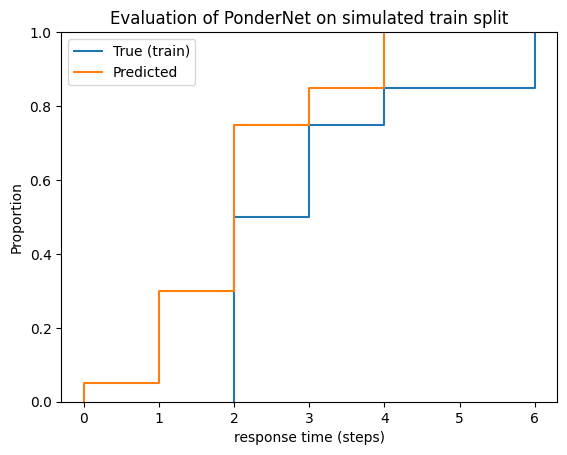

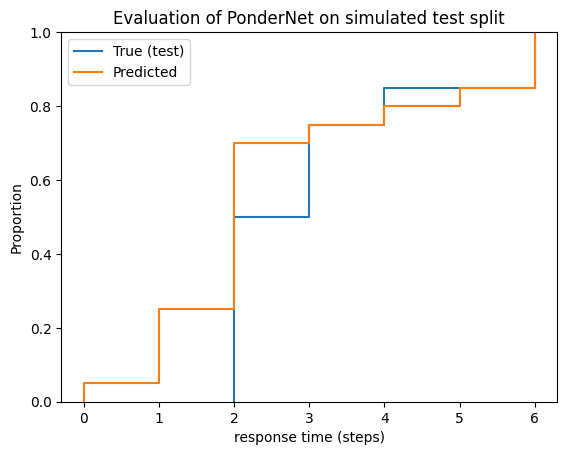

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.ecdfplot(rt_train.detach(), label='True (train)')
sns.ecdfplot(rt_train_pred.detach(), label='Predicted')

plt.title('Evaluation of PonderNet on simulated train split')
plt.xlabel('response time (steps)')

plt.legend()
plt.show()

sns.ecdfplot(rt_test.detach(), label='True (test)')
sns.ecdfplot(rt_test_pred.detach(), label='Predicted')

plt.title('Evaluation of PonderNet on simulated test split')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()

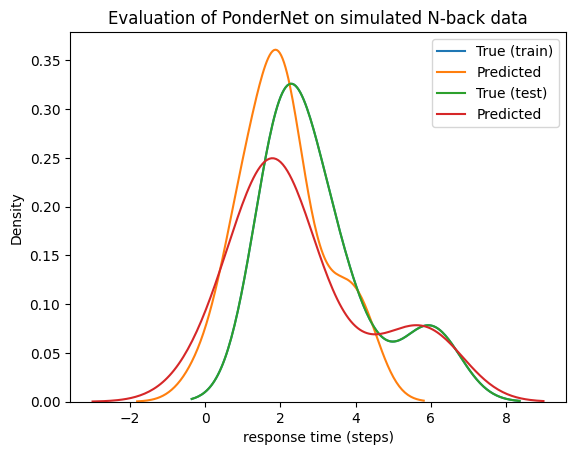

In [9]:

sns.kdeplot(rt_train.detach(), label='True (train)')
sns.kdeplot(rt_train_pred.detach(), label='Predicted')

sns.kdeplot(rt_test.detach(), label='True (test)')
sns.kdeplot(rt_test_pred.detach(), label='Predicted')


plt.title('Evaluation of PonderNet on simulated N-back data')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()